 ```python
 !pip install pydot
 # keras 모델 구조를 시각화해주는 도구
 # 세션 다시 시작 필요!
 ```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)

/content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)


In [4]:
!pwd

/content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
from tensorflow.keras.applications import EfficientNetV2S # 최신 이미지 분류 모델 중에 하나

In [7]:
data = np.load("./data/brain_tumor_data.npz")
data
# npz 확장자 : numpy에서 제공된 확장자로, 압축된 형식의 배여ㅛㄹ로 저장(바이너리 파일)

NpzFile './data/brain_tumor_data.npz' with keys: X_train, X_test, y_train, y_test, DESC

In [8]:
print(data["DESC"])

[brain_tumor_dataset] 24.01.22 created by sjy, data from kaggle
                    name of classes:
                    - [0-'glioma_tumor', 1- 'meningioma_tumor', 2- 'no_tumor',3- 'pituitary_tumor']
                    - glioma tumor 신경교종: 뇌와 척수의 내부에 있는 신경교세포에서 기원하는 종양
                    - meningioma tumor 뇌수막종: 뇌를 둘러싸고 있는 지주막 세포에서 기원하는 종양
                    - no_tumor 종양x
                    - pituitary adenoma 뇌하수체 종양: 뇌 조직 중 호르몬 분비를 담당하는 뇌하수체에 발생하는 모든 양성 종양

                    data info
                    - X_train2: (2870, 224, 224, 3)
                    - y_train2: (2870, 4)
                    - X_test2: (394, 224, 224, 3)
                    - y_test2: (394, 4)
                    


### 전이학습 (Transfer Learning)
- 사전학습모델을 활용해서 내 데이터셋으로 추가 학습하는 일련의 과정

### 미세조정 (Fine Tuning)
- 적은 학습률(α, Learning rate)을 기반으로 내 데이터셋에 fit하게 학습하는 과정



In [9]:
# 각각의 데이터들 변수에 할당
X_train = data["X_train"]
X_test = data["X_test"]
y_train = data["y_train"]
y_test = data["y_test"]

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2870, 224, 224, 3), (394, 224, 224, 3), (2870, 4), (394, 4))

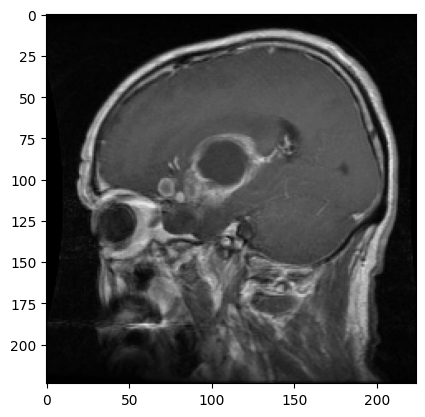

In [11]:
plt.imshow(X_train[50].astype("int64")) #RGB 데이터인데, 부동소수점 표현되어 있어서, int형으로 형변환
plt.show()

In [12]:
y_train[50]

array([1., 0., 0., 0.], dtype=float32)

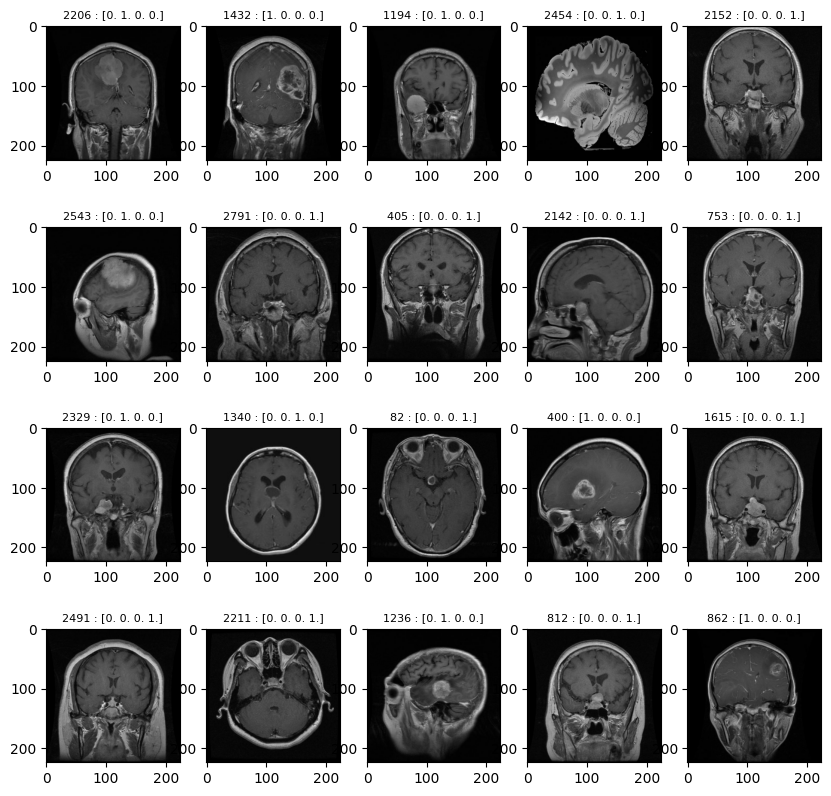

In [13]:
# 랜덤하게 인덱스 선택해서 이미지 출력
plt.figure(figsize = (10,10))
rd_list = np.random.randint(0,2870, size = 20)

for i in range(len(rd_list)) :
  plt.subplot(4,5,i+1)

  # 각각의 이미지 정보 출력
  plt.title(f"{rd_list[i]} : {y_train[rd_list[i]]}", fontdict = {"fontsize" : 8})

  # 각각의 이미지 그리기
  plt.imshow(X_train[rd_list[i]].astype("int32"))


####전이학습 수행

In [14]:
# 모델 가져오기
image_prepro = EfficientNetV2S(
    include_top = False,
    weights = "imagenet", # 수천가지 카테고리별로 학습된 가중치
    input_shape = (224,224,3),
    pooling = "max" # 최종 출력에서 Global Max Pooling을 적용
)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.28352 to fit



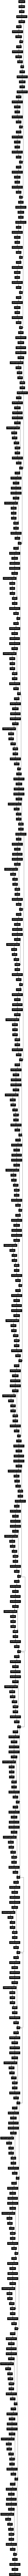

In [15]:
from tensorflow.keras.utils import plot_model # 시각화 도구(pydot 필요)
plot_model(image_prepro) # 모델의 각 층을 네트워크 다이어그램 형으로 보여줌

In [16]:
# 뼈대
tumor_model = Sequential()

# 특성추출부
tumor_model.add(image_prepro)

# 분류부
tumor_model.add(Flatten())
tumor_model.add(Dense(2048,"relu"))
tumor_model.add(Dense(1024,"relu"))
tumor_model.add(Dense(512,"relu"))
tumor_model.add(Dropout(0.2))
tumor_model.add(Dense(256,"relu"))

tumor_model.add(Dense(4, "softmax")) # 출력층

In [17]:
# 학습방법 설정
tumor_model.compile(
    loss = "categorical_crossentropy", # 다중 분류 시, y데이터가 원핫 벡터인 경우 적용 !
    # sparse_categorical_crossentropy : y 데이터가 1차원인 경우 적용!
    metrics = ["accuracy"],
    optimizer = "adam"
)

In [18]:
# 조기학습중단
early = EarlyStopping(
    monitor = "val_accuracy",
    patience = 8, # 인내하는 정도
    verbose = 1
)

In [24]:
# 학습
h = tumor_model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs = 100,
                    callbacks = [early],
                    batch_size = 32)

Epoch 1/100


KeyboardInterrupt: 

In [35]:
tumor_model.evaluate(X_test, y_test)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_5" is incompatible with the layer: expected axis -1 of input shape to have value 5184, but received input with shape (None, 12544)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • training=False
  • mask=None

- 딥러닝 성능을 끌어올려보자!
- 팀별로 성능 확인 !! -> 4:40에 evaluate의 가장 좋은 값들을 캡처해서 올리기 !

In [19]:
from tensorflow.keras.layers import BatchNormalization

In [24]:
# 모델 가져오기 (전이 학습 기반)
image_prepro = EfficientNetV2S(
    include_top=False,
    weights="imagenet",  # 수천가지 카테고리별로 학습된 가중치
    input_shape=(224, 224, 3),
    pooling="max"  # 최종 출력에서 Global Max Pooling을 적용
)

from tensorflow.keras.utils import plot_model
plot_model(image_prepro)

# 뼈대
tumor_model = Sequential()

# 특성추출부
tumor_model.add(image_prepro)

# 분류부
tumor_model.add(Flatten())
tumor_model.add(Dense(2048, activation="relu"))
tumor_model.add(BatchNormalization())

tumor_model.add(Dense(1024, activation="relu"))
tumor_model.add(BatchNormalization())

tumor_model.add(Dense(512, activation="relu"))
tumor_model.add(BatchNormalization())

tumor_model.add(Dropout(0.2))

tumor_model.add(Dense(256, activation="relu"))
tumor_model.add(BatchNormalization())

tumor_model.add(Dense(4, activation="softmax"))



dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.28352 to fit



In [25]:
# 학습방법 설정
tumor_model.compile(
    loss="categorical_crossentropy",  # 다중 분류 시 y데이터가 원핫 벡터인 경우
    metrics=["accuracy"],
    optimizer="adam"
)

In [26]:
# 조기학습중단
early = EarlyStopping(
    monitor="val_accuracy",
    patience=8,  # 인내하는 정도
    verbose=1
)

In [27]:
# 학습
h = tumor_model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    callbacks=[early],
                    batch_size=32)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.6534 - loss: 1.0161 - val_accuracy: 0.7718 - val_loss: 0.9536
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8783 - loss: 0.3411 - val_accuracy: 0.9007 - val_loss: 0.4138
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 374ms/step - accuracy: 0.9345 - loss: 0.2111 - val_accuracy: 0.9582 - val_loss: 0.1725
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9345 - loss: 0.1776 - val_accuracy: 0.9373 - val_loss: 0.2981
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 364ms/step - accuracy: 0.9667 - loss: 0.1118 - val_accuracy: 0.9617 - val_loss: 0.1569
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 367ms/step - accuracy: 0.9792 - loss: 0.0650 - val_accuracy: 0.9460 - val_loss: 0.1923
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 358ms/step - accuracy: 0.9818 - loss: 0.0574 - val_accuracy: 0.9408 - val_loss: 0.2143
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9721 - loss: 0.0845 - va

In [28]:
tumor_model.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 766ms/step - accuracy: 0.8134 - loss: 1.3295


[1.4225335121154785, 0.8045685291290283]